In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow import keras
from tensorflow.keras.models import Sequential
from datetime import datetime
from keras import optimizers
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from keras.utils import normalize
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter (action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [ ]:
def repeat_elem(tensor, rep):


     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [ ]:
def res_conv_block(x, filter_size, size):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    conv = layers.BatchNormalization(axis=3)(conv)
    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    shortcut = layers.BatchNormalization(axis=3)(shortcut)
    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path


In [ ]:
def gating_signal(input, out_size):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    up_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                  strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                  padding='same')(phi_g)

    concat_xg = layers.add([up_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    up_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    up_psi = repeat_elem(up_psi, shape_x[3])

    y = layers.multiply([up_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [ ]:
def Attention_ResUNet(input_shape):

    FILTER_NUM = 64
    FILTER_SIZE = 3
    UP_SAMP_SIZE = 2

    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3


    conv = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM)
    pool = layers.MaxPooling2D(pool_size=(2,2))(conv)

    conv2 = res_conv_block(pool, FILTER_SIZE, 2*FILTER_NUM)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = res_conv_block(pool2, FILTER_SIZE, 4*FILTER_NUM)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = res_conv_block(pool3, FILTER_SIZE, 8*FILTER_NUM)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = res_conv_block(pool4, FILTER_SIZE, 16*FILTER_NUM)


    gating4 = gating_signal(conv5, 8*FILTER_NUM)
    att4 = attention_block(conv4, gating4, 8*FILTER_NUM)
    up4 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv5)
    up4 = layers.concatenate([up4, att4], axis=axis)
    up_conv4 = res_conv_block(up4, FILTER_SIZE, 8*FILTER_NUM)

    gating3 = gating_signal(up_conv4, 4*FILTER_NUM)
    att3 = attention_block(conv3, gating3, 4*FILTER_NUM)
    up3 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv4)
    up3 = layers.concatenate([up3, att3], axis=axis)
    up_conv3 = res_conv_block(up3, FILTER_SIZE, 4*FILTER_NUM)

    gating2 = gating_signal(up_conv3, 2*FILTER_NUM)
    att2 = attention_block(conv2, gating2, 2*FILTER_NUM)
    up2 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv3)
    up2 = layers.concatenate([up2, att2], axis=axis)
    up_conv2 = res_conv_block(up2, FILTER_SIZE, 2*FILTER_NUM)

    gating1 = gating_signal(up_conv2, FILTER_NUM)
    att1 = attention_block(conv1, gating1, FILTER_NUM)
    up1 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv2)
    up1 = layers.concatenate([up1, att1], axis=axis)
    up_conv1 = res_conv_block(up1, FILTER_SIZE, FILTER_NUM)


    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv1)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)


    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


In [ ]:
image_directory = '/content/gdrive/MyDrive/ISTD/train/train_A'
mask_directory = '/content/gdrive/MyDrive/ISTD/train/train_B'


image_files = sorted(os.listdir(image_directory))
mask_files = sorted(os.listdir(mask_directory))


file_pairs = [(os.path.join(image_directory, image_files[i]), os.path.join(mask_directory, mask_files[i])) for i in range(len(image_files))]

image_paths, mask_paths = zip(*file_pairs)


df = pd.DataFrame({'image_paths': image_paths, 'mask_paths': mask_paths})


image_datagen = ImageDataGenerator(rescale=1./255)

mask_datagen = ImageDataGenerator(rescale=1./255)


train_df = df.sample(frac=0.9)
val_df = df.drop(train_df.index)

SIZE = 256

train_image_generator = image_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_paths',
    y_col=None,
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode=None,
    batch_size=16,
    shuffle=False,
    seed=SEED,
)


val_image_generator = image_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_paths',
    y_col=None,
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode=None,
    batch_size=16,
    shuffle=False,
    seed = SEED
)


train_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='mask_paths',
    y_col=None,
    target_size=(SIZE, SIZE),
    color_mode='grayscale',
    class_mode=None,
    batch_size=16,
    shuffle=False,
    seed=SEED
)


val_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='mask_paths',
    y_col=None,
    target_size=(SIZE, SIZE),
    color_mode='grayscale',
    class_mode=None,
    batch_size=16,
    shuffle=False,
    preprocessing_function=threshold_mask,
    seed = SEED
)

Found 1197 validated image filenames.
Found 133 validated image filenames.
Found 1197 validated image filenames.
Found 133 validated image filenames.


In [ ]:
image_dataset = train_image_generator.next()
mask_dataset = train_mask_generator.next()


print(np.shape(image_dataset))
print(np.shape(mask_dataset))

(16, 256, 256, 3)
(16, 256, 256, 1)


In [ ]:
np.unique(mask_dataset[2])

array([0., 1.], dtype=float32)

In [ ]:
len(image_dataset[0])

256

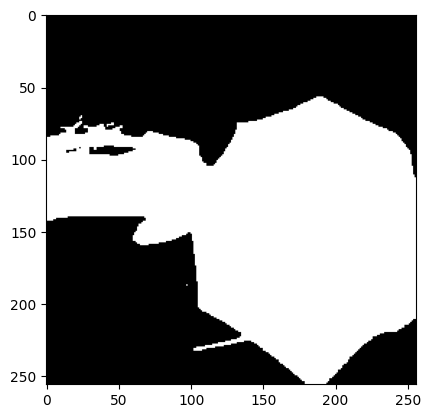

In [ ]:
plt.imshow(mask_dataset[0], cmap='gray')


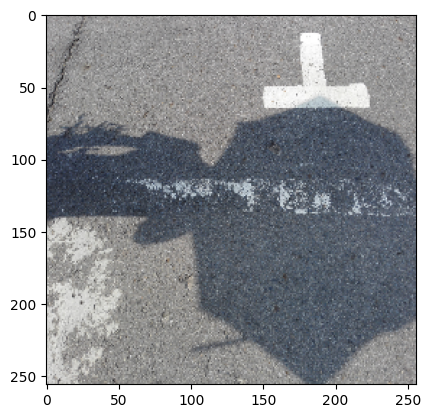

In [ ]:
plt.imshow(image_dataset[0])

In [ ]:
print(image_dataset.shape)
print(mask_dataset.shape)

(16, 256, 256, 3)
(16, 256, 256, 1)


In [ ]:

train_steps_per_epoch = len(train_image_generator)
val_steps_per_epoch = len(val_image_generator)
print(train_steps_per_epoch, val_steps_per_epoch)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)



75 9


In [ ]:
input_shape = (SIZE, SIZE, 3)


model = Attention_ResUNet(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


print(model.summary())
history = model.fit(
    train_generator,
    verbose=1,
    validation_data=val_generator,
    steps_per_epoch = 75,
    validation_steps = 9,
    epochs=50,
    shuffle=False
)




Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

In [ ]:
model.save('AttResUnet.h5')
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


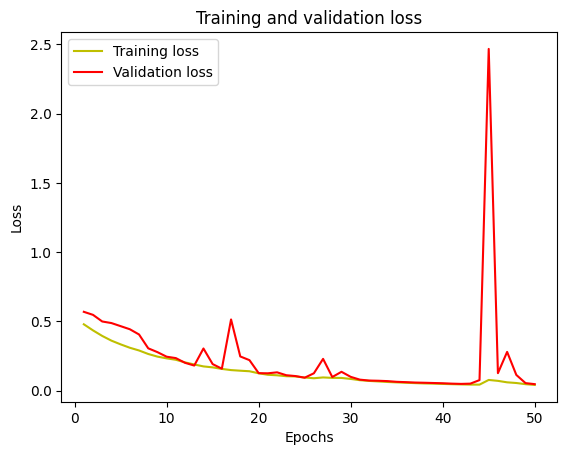

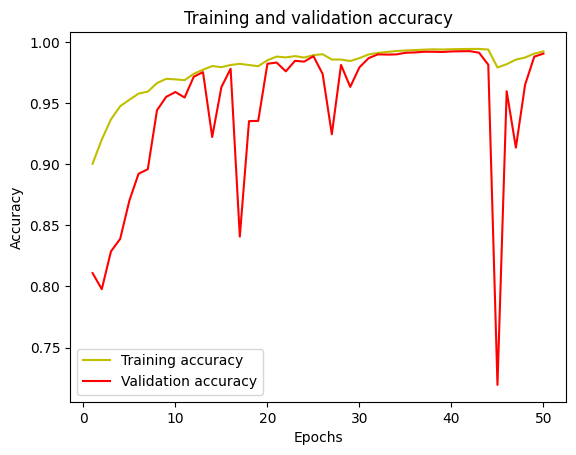

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




In [ ]:
model_path = "AttResUnet.h5"

model1 = tf.keras.models.load_model(model_path, compile=False)

In [ ]:
test_image_directory = '/content/gdrive/MyDrive/ISTD_Dataset/test/test_A'
test_mask_directory = '/content/gdrive/MyDrive/ISTD_Dataset/test/test_B'

SIZE = 256
test_image_dataset = []
test_mask_dataset = []

test_images = os.listdir(test_image_directory)
for i, image_name in enumerate(test_images):
    image = cv2.imread(test_image_directory+'/'+image_name)
    image = Image.fromarray(image)
    image = image.resize((SIZE, SIZE))
    test_image_dataset.append(np.array(image))
    image1 = cv2.imread(test_mask_directory+'/'+image_name, 0)
    image1 = Image.fromarray(image1)
    image1 = image1.resize((SIZE, SIZE))
    test_mask_dataset.append(np.array(image1))

In [ ]:
#Normalize images

test_image_dataset = np.array(test_image_dataset).astype(np.float64)

test_mask_dataset = np.array(test_mask_dataset).astype(np.float64)
test_image_dataset /= 255
test_mask_dataset /= 255

test_mask_dataset = (test_mask_dataset >0.5).astype(np.uint8)

In [ ]:
np.unique(test_mask_dataset[0])

array([0, 1], dtype=uint8)

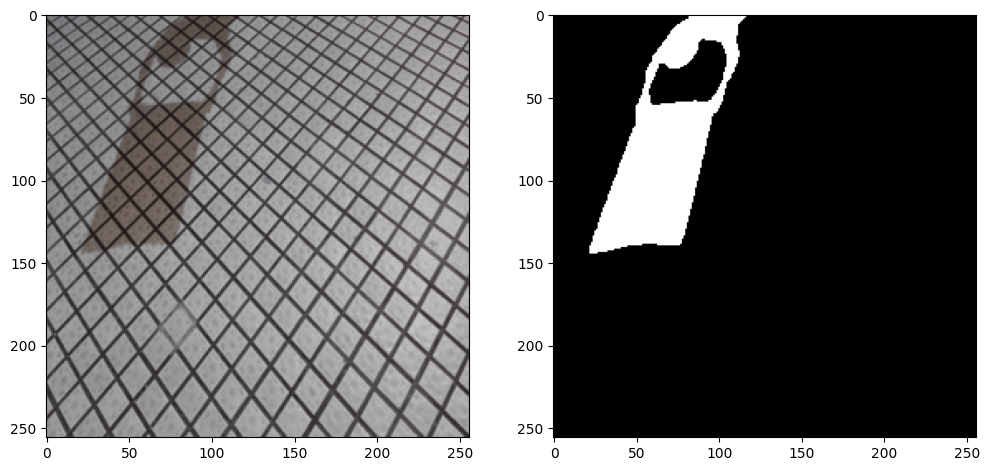

In [ ]:
#Sanity check

image_number = random.randint(0, len(test_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(test_image_dataset[image_number])
plt.subplot(122)
plt.imshow(test_mask_dataset[image_number], cmap='gray')
plt.show()

In [ ]:
_, acc = model.evaluate(test_image_dataset, test_mask_dataset)

17/17 [==============================] - 63s 2s/step - loss: 0.4541 - accuracy: 0.8682


In [ ]:
print(acc*100)

86.82101964950562


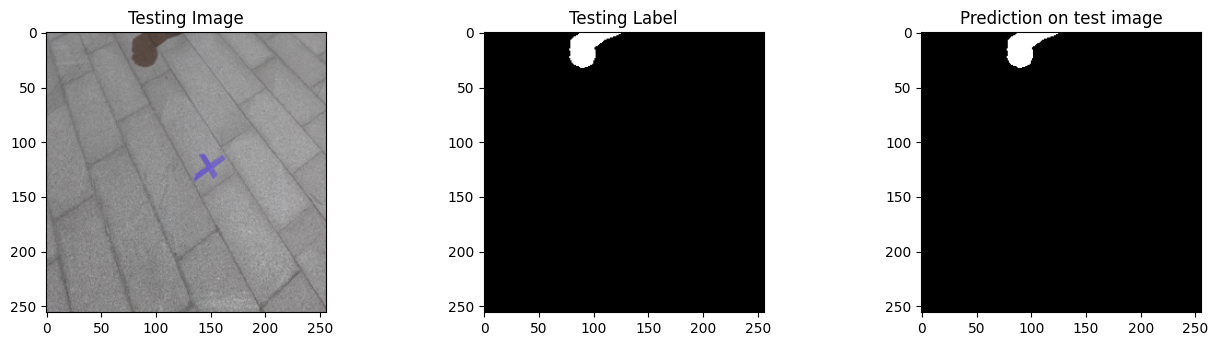

In [ ]:



import random
test_img_number = random.randint(0, test_image_dataset.shape[0]-1)
test_img = test_image_dataset[test_img_number]
ground_truth=test_mask_dataset[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input)> 0.5).astype(np.uint8)
prediction = prediction[0]
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()



In [ ]:

#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
# IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras.update_state(ground_truth, prediction)
# print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average

import pandas as pd
import random
IoU_values = []
for img in range(0, test_image_dataset.shape[0]):
    temp_img = test_image_dataset[img]
    ground_truth=test_mask_dataset[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model1.predict(temp_img_input)> 0.5).astype(np.uint8)
    prediction = prediction[0]
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth, prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1/1 [==============================] - 1s 757ms/step
0.71622527
1/1 [==============================] - 1s 805ms/step
0.55446887
1/1 [==============================] - 1s 784ms/step
0.2421869
1/1 [==============================] - 1s 773ms/step
0.6945051
1/1 [==============================] - 1s 1s/step
0.40875727
1/1 [==============================] - 1s 1s/step
0.046439413
1/1 [==============================] - 1s 768ms/step
0.60810286
1/1 [==============================] - 1s 784ms/step
0.25069594
1/1 [==============================] - 1s 796ms/step
0.06774597
1/1 [==============================] - 1s 785ms/step
0.04246274
1/1 [==============================] - 1s 776ms/step
0.65724
1/1 [==============================] - 1s 758ms/step
0.67651165
1/1 [==============================] - 1s 763ms/step
0.95796525
1/1 [==============================] - 1s 775ms/step
0.8303133
1/1 [==============================] - 1s 744ms/step
0.03203155
1/1 [==============================] - 1s 1s/step
0

In [ ]:
test_predictions = model1.predict(test_image_dataset) > 0.5
test_predictions = test_predictions.astype(np.uint8)


17/17 [==============================] - 14s 873ms/step


In [ ]:
test_predictions.shape

(540, 256, 256, 1)

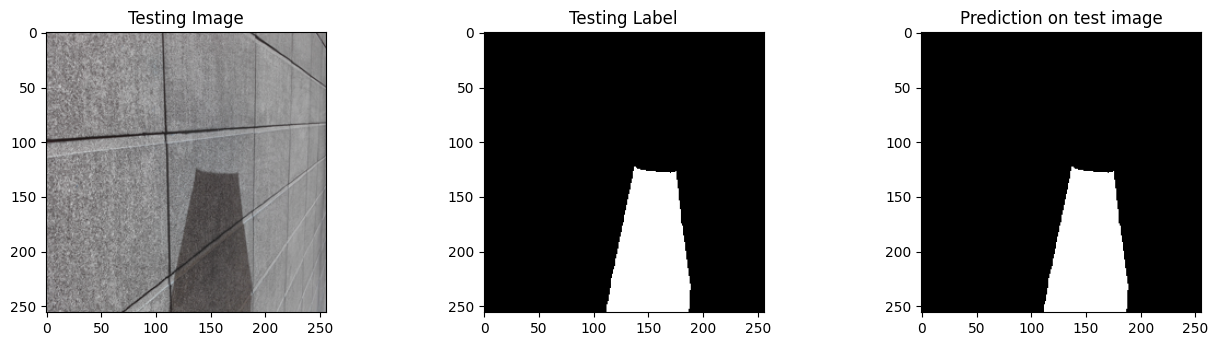

In [ ]:
test_img_number = random.randint(0, len(test_image_dataset))
test_img = test_image_dataset[test_img_number]
ground_truth=test_mask_dataset[test_img_number]
prediction = test_predictions[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()